# Computing centralities from OSM data


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

## Data and Extents

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

For additional information on network preparation, see the corresponding discussion on [graph cleaning](https://cityseer.benchmarkurbanism.com/guide#graph-cleaning).


In [2]:
from shapely import geometry

from cityseer.tools import graphs, io

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
plot_buffer = 3500
# creates a WGS shapely polygon
poly_wgs, poly_utm, _utm_zone_number, _utm_zone_letter = io.buffered_point_poly(lng, lat, buffer)
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

/Users/gareth/dev/benchmark-urbanism/cityseer-api/.venv/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
INFO:cityseer.tools.io:UTM conversion info: UTM zone number: 30, UTM zone letter: U


## Load

We can now load the OSM dataset and convert it to a format that can be used by cityseer for downstream calculations.

In [3]:
# generate OSM graph from polygon
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True, remove_parallel=True, iron_edges=False)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_utm, 25)
# prepare the data structures
nodes_gdf, network_structure = graphs.network_structure_from_nx(G_decomp, crs=32629)

INFO:cityseer.tools.graphs:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 143811/143811 [00:01<00:00, 124833.02it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 161654/161654 [00:00<00:00, 761012.11it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 161654/161654 [00:05<00:00, 28479.96it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 143811/143811 [00:25<00:00, 5556.28it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 46005/46005 [00:00<00:00, 365046.73it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 41713/41713 [00:00<00:00, 44649.08it/s]
INFO:cityseer.tools.graphs:Creating nodes STR tree
100%|██████████| 38951/38951 [00:01<00:00, 33622.56it/s]
/Users/gareth/dev/benchmark-urbanism/cityseer-api/cityseer/tools/graphs.py:1266: ShapelyDepre

## Calculate centralities

The centrality methods can now be computed.

In [4]:
from cityseer.metrics import networks

# this will take around 5-8 minutes depending on the available resources
# if you want to compute wider area centralities, e.g. 20km, then use less decomposition to speed up the computation
nodes_gdf = networks.node_centrality(
    measures=["node_beta", "node_betweenness"],
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=[250, 500, 2000],
)

INFO:cityseer.metrics.networks:Computing node_beta, node_betweenness centrality measures using shortest (non-angular) path heuristic.


100%|██████████| 90246.0/90246 [07:13<00:00, 208.37it/s]


## Plots

Let's plot a selection of distance thresholds for each of the computed measures.


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 87.57m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


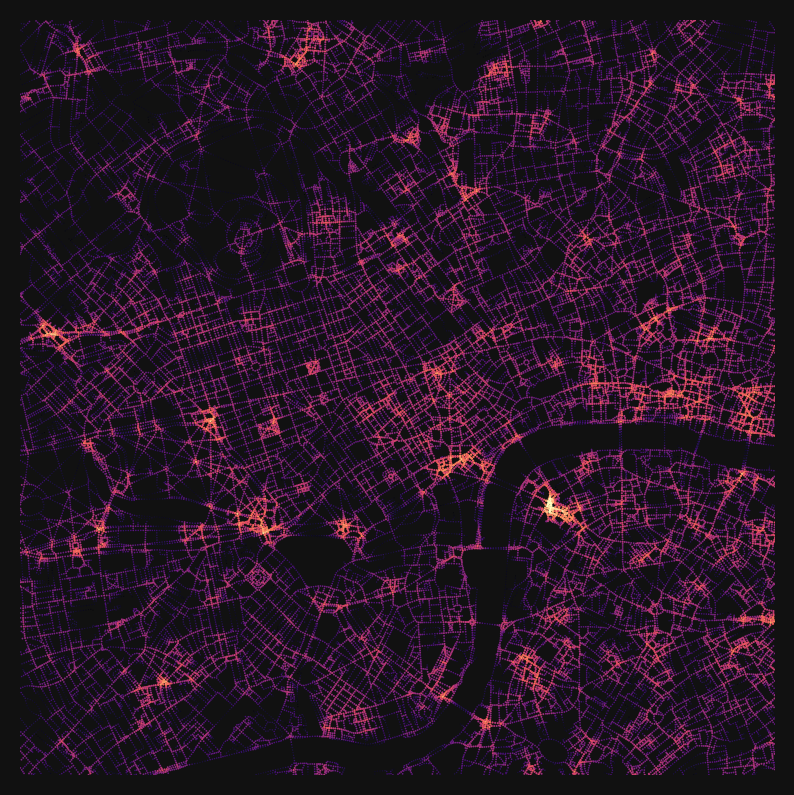


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 175.37m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


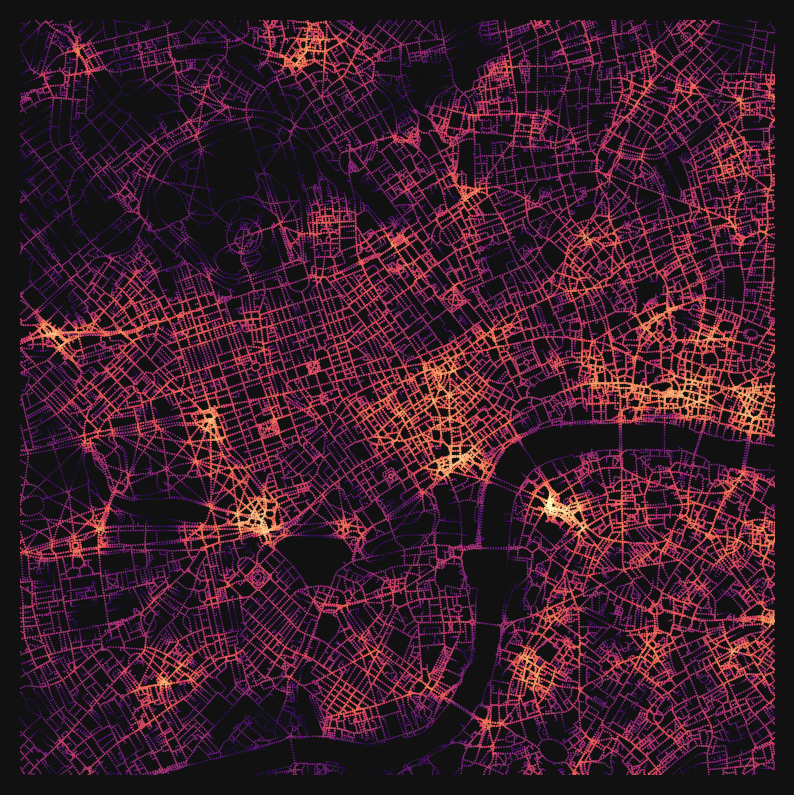


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


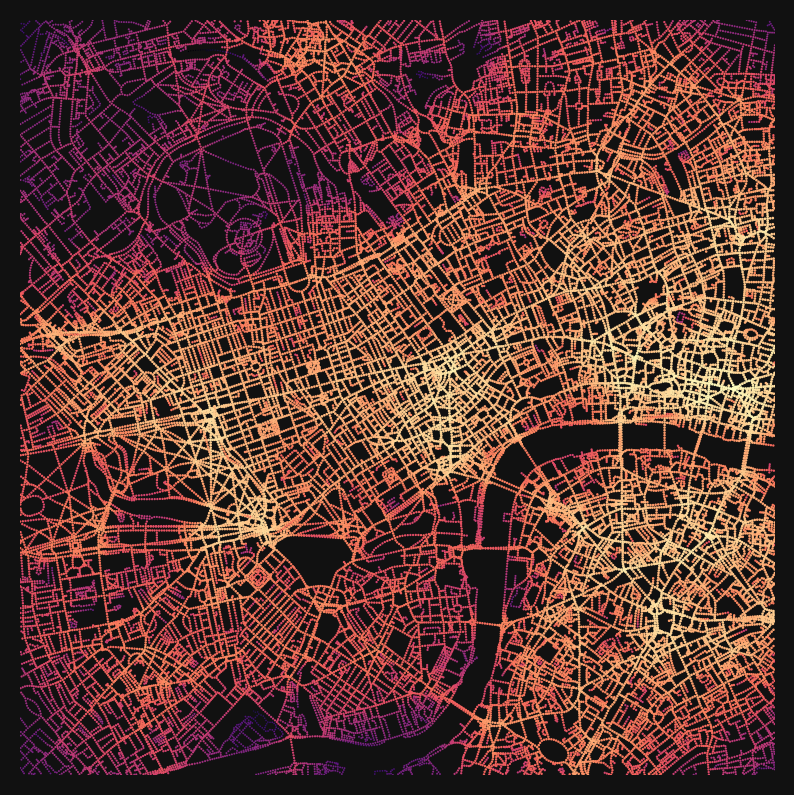


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 87.57m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


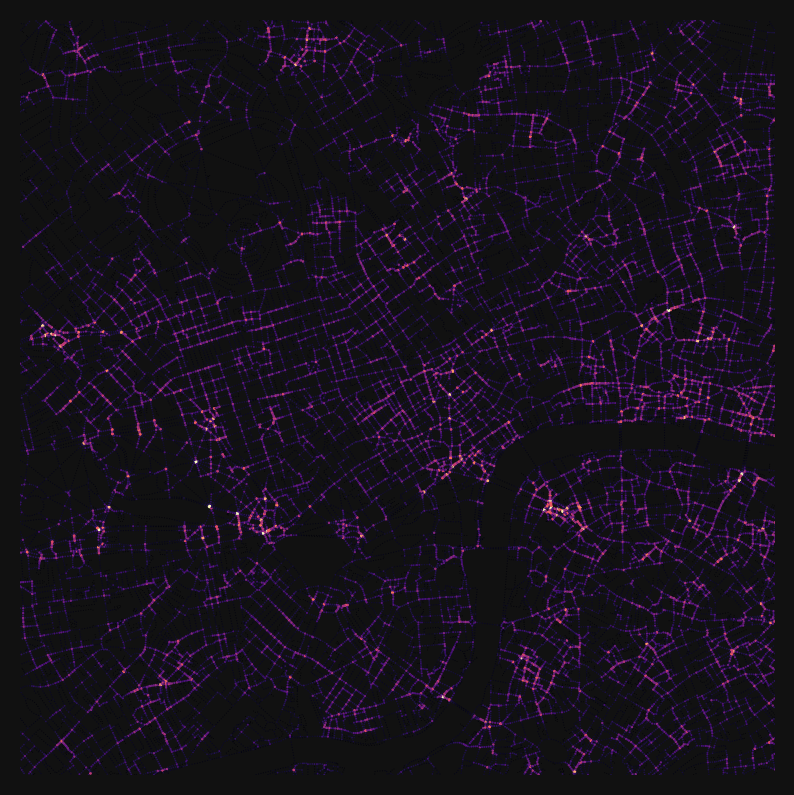


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 175.37m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


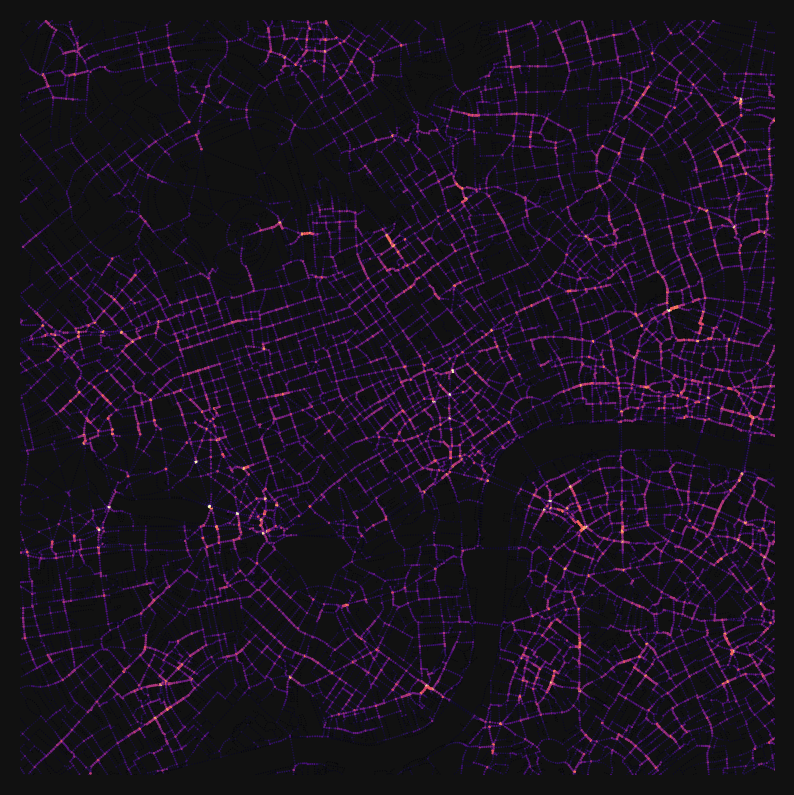


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


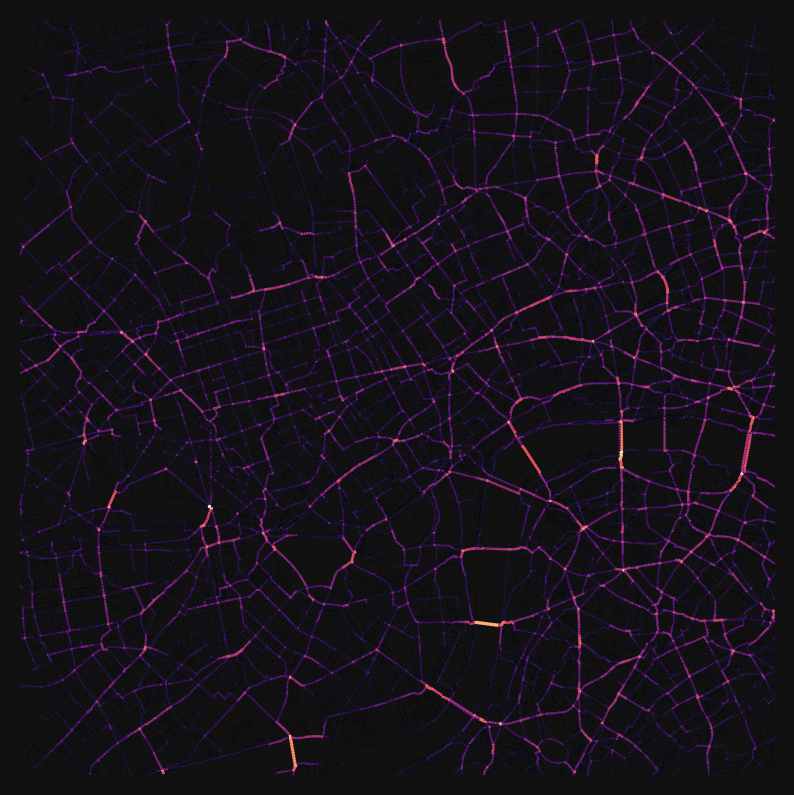

In [5]:
import matplotlib.pyplot as plt

from cityseer.tools import plot

bg_colour = "#111"
for d in [250, 500, 2000]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        ax,
        network_structure.nodes.xs,
        network_structure.nodes.ys,
        nodes_gdf[f"cc_metric_node_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    plt.show()

for d in [250, 500, 2000]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        ax,
        network_structure.nodes.xs,
        network_structure.nodes.ys,
        nodes_gdf[f"cc_metric_node_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    plt.show()